In [ ]:
#starting imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import cv2
from tqdm import tqdm

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Data processing

In [ ]:
#left eye represented by 0 and right eye 1
#this shell converting the images into array and with some scripting I stored the label from its name
training_data = []
path = "‪/content/drive/MyDrive/left eye right eye/left right images".rsplit("\u202a")[1]
IMG_SIZE = 28
for img in tqdm(os.listdir(path)):  
    if 'left' in img:
        class_num = 0
    else:
        class_num = 1
    try:
        img_array = cv2.imread(os.path.join(path,img) ,cv2.IMREAD_GRAYSCALE)  
        new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE)) 
        training_data.append([new_array, class_num]) 
    except Exception as e:
        print("problem")
        break

100%|██████████| 12082/12082 [06:02<00:00, 33.34it/s] 


In [ ]:
#separating image's array and labels of them
X = []
y = []

for features,label in training_data:
    X.append(features)
    y.append(label)

#reshaping as every pixel can a single array 
X = np.array(X).reshape(-1, IMG_SIZE, IMG_SIZE, 1) 

#converting all into 0 to 1, as 255 is the max value in color cmbination
X = X/255.0

In [ ]:
y = np.array(y)

The CNN approach 

In [ ]:
#all keras imports

from keras.models import Sequential,load_model,model_from_json
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.callbacks import EarlyStopping

In [ ]:
#early stop
es = EarlyStopping(monitor='val_accuracy')

In [ ]:
#the model
model2 = Sequential()  

model2.add(Conv2D(512,kernel_size=3,activation='relu',input_shape=(IMG_SIZE,IMG_SIZE,1)))
model2.add(MaxPooling2D(2))

model2.add(Conv2D(128,kernel_size=3,activation='relu',input_shape=(IMG_SIZE,IMG_SIZE,1)))
model2.add(MaxPooling2D(2))
model2.add(Conv2D(64,kernel_size=3,activation='relu',input_shape=(IMG_SIZE,IMG_SIZE,1)))
model2.add(Conv2D(64,kernel_size=3,activation='relu',input_shape=(IMG_SIZE,IMG_SIZE,1)))

model2.add(Flatten())
model2.add(Dense(2,activation='softmax'))

In [ ]:
model2.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'],run_eagerly=True)

In [ ]:
#because of early stoping itteration stoped 
training = model2.fit(X, y, epochs=15, validation_split=0.2)

Epoch 1/15
303/303 [==============================] - 161s 530ms/step - loss: 0.3183 - accuracy: 0.8473 - val_loss: 0.1452 - val_accuracy: 0.9462
Epoch 2/15
303/303 [==============================] - 149s 493ms/step - loss: 0.1430 - accuracy: 0.9437 - val_loss: 0.1113 - val_accuracy: 0.9611
Epoch 3/15
303/303 [==============================] - 148s 490ms/step - loss: 0.1213 - accuracy: 0.9571 - val_loss: 0.0905 - val_accuracy: 0.9648
Epoch 4/15
303/303 [==============================] - 149s 490ms/step - loss: 0.1084 - accuracy: 0.9602 - val_loss: 0.0941 - val_accuracy: 0.9615
Epoch 5/15
303/303 [==============================] - 149s 492ms/step - loss: 0.1005 - accuracy: 0.9663 - val_loss: 0.0913 - val_accuracy: 0.9669
Epoch 6/15
303/303 [==============================] - 148s 487ms/step - loss: 0.0914 - accuracy: 0.9692 - val_loss: 0.0797 - val_accuracy: 0.9694
Epoch 7/15
303/303 [==============================] - 149s 493ms/step - loss: 0.0851 - accuracy: 0.9718 - val_loss: 0.0688 -

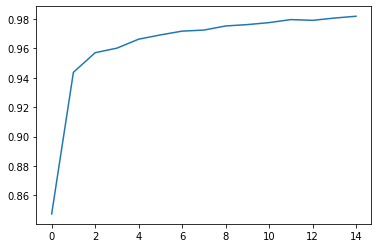

In [ ]:
#below two graph is showing us there is no overfitting and I handle it with early stoping 
plt.plot(training.history['accuracy'])

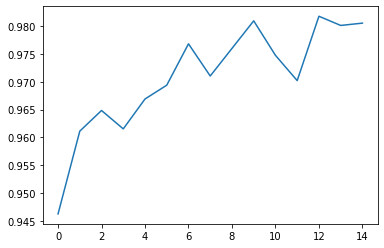

In [ ]:
plt.plot(training.history['val_accuracy'])

In [ ]:
#As keras dont suffle before splitting, so last 20% must be the test dataset. I will use this for creating a confusion matrix
test_data = training_data[9642:12052]


In [ ]:
#making the data feedable
X_test = []
y_test = []

for features,label in test_data:
    X_test.append(features)
    y_test.append(label)

X_test = np.array(X_test).reshape(-1, IMG_SIZE, IMG_SIZE, 1) 

X_test = X_test/255.0

In [ ]:
#predicting with the test data 

predict_x= model2.predict(X_test) 
y_predict=np.argmax(predict_x,axis=1)
# predictions = (model2.predict(X_test) > 0.5).astype("int32")


In [ ]:
#creating the confusion matrix
from sklearn.metrics import confusion_matrix

con_matrix = confusion_matrix(y_test, y_predict)
con_matrix

array([[1177,   29],
       [  18, 1186]])

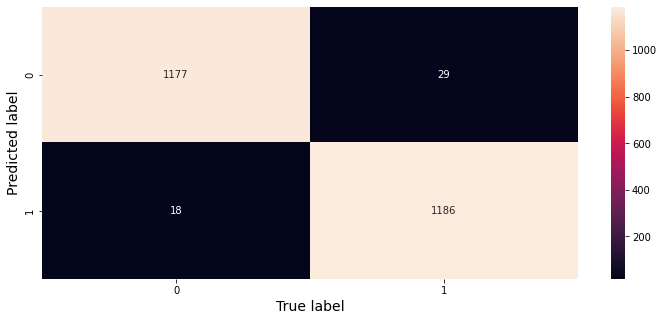

In [ ]:
#some better visualization
import seaborn as sn
import matplotlib.pyplot as plt
%matplotlib inline
f, ax = plt.subplots(figsize=(12,5))
sn.heatmap(con_matrix , annot=True,fmt="d")
ax.set_xlabel('True label', size=14)
ax.set_ylabel('Predicted label',size=14)

plt.rc('xtick', labelsize=12) 
plt.rc('ytick', labelsize=12)
plt.show()

In [ ]:
#the summery and structure of my model
model2.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 512)       5120      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 13, 13, 512)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 11, 11, 128)       589952    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 5, 5, 128)        0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 3, 3, 64)          73792     
                                                                 
 conv2d_3 (Conv2D)           (None, 1, 1, 64)          3

In [ ]:
from sklearn.metrics import precision_recall_fscore_support as score



precision, recall, fscore, support = score(y_test, y_predict)

print('precision: {}'.format(precision))
print('recall: {}'.format(recall))
print('fscore: {}'.format(fscore))
print('support: {}'.format(support))


precision: [0.98493724 0.97613169]
recall: [0.97595357 0.98504983]
fscore: [0.98042482 0.98057048]
support: [1206 1204]


With ML Algorithms


In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
X_reshaped = X.reshape((12082, -1))

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_reshaped, y, test_size=0.20, random_state=42)

SVM

In [ ]:
from sklearn import svm
svm = svm.SVC()
svm.fit(X_train, y_train)


SVC()

In [ ]:
svm.score(X_test,y_test)

svmPredict = svm.predict(X_test)

In [ ]:
from sklearn.metrics import precision_recall_fscore_support as score



precision, recall, fscore, support = score(y_test, svmPredict)

print('precision: {}'.format(precision))
print('recall: {}'.format(recall))
print('fscore: {}'.format(fscore))
print('support: {}'.format(support))

precision: [0.9132948  0.94112769]
recall: [0.93967715 0.91532258]
fscore: [0.92629816 0.92804579]
support: [1177 1240]


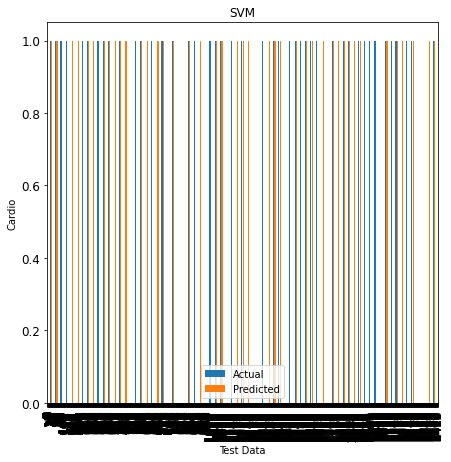

In [ ]:
df = pd.DataFrame({'Actual': y_test, 'Predicted': svmPredict})
df.plot(kind='bar',figsize=(7,7),xlabel='Test Data',ylabel='Cardio',title='SVM')
plt.show()

In [ ]:
#creating the confusion matrix
from sklearn.metrics import confusion_matrix

con_matrix = confusion_matrix(y_test, svmPredict)
con_matrix

array([[1106,   71],
       [ 105, 1135]])

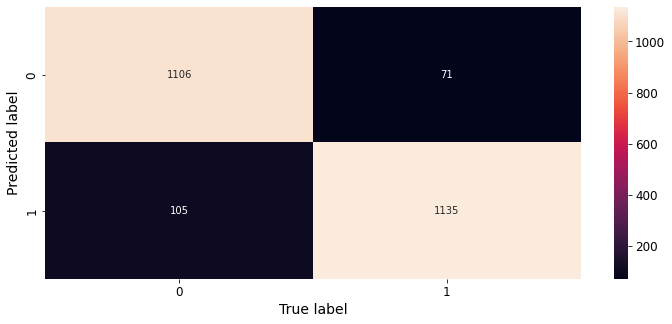

In [ ]:
#some better visualization
import seaborn as sn
import matplotlib.pyplot as plt
%matplotlib inline
f, ax = plt.subplots(figsize=(12,5))
sn.heatmap(con_matrix , annot=True,fmt="d")
ax.set_xlabel('True label', size=14)
ax.set_ylabel('Predicted label',size=14)

plt.rc('xtick', labelsize=12) 
plt.rc('ytick', labelsize=12)
plt.show()

Random forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(max_depth=2, random_state=0)
rf.fit(X_train, y_train)

RandomForestClassifier(max_depth=2, random_state=0)

In [ ]:
rf.score(X_test,y_test)

0.6793545717832024

In [ ]:
rfPredict = rf.predict(X_test)

In [ ]:
from sklearn.metrics import precision_recall_fscore_support as score



precision, recall, fscore, support = score(y_test, rfPredict)

print('precision: {}'.format(precision))
print('recall: {}'.format(recall))
print('fscore: {}'.format(fscore))
print('support: {}'.format(support))

precision: [0.74512195 0.64558547]
recall: [0.5191164  0.83145161]
fscore: [0.61191788 0.72682411]
support: [1177 1240]


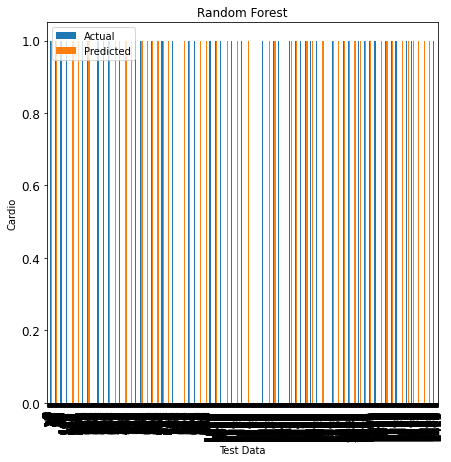

In [ ]:
df = pd.DataFrame({'Actual': y_test, 'Predicted': rfPredict})
df.plot(kind='bar',figsize=(7,7),xlabel='Test Data',ylabel='Cardio',title='Random Forest')
plt.show()

In [ ]:
#creating the confusion matrix
from sklearn.metrics import confusion_matrix

con_matrix = confusion_matrix(y_test, rfPredict)
con_matrix

array([[ 611,  566],
       [ 209, 1031]])

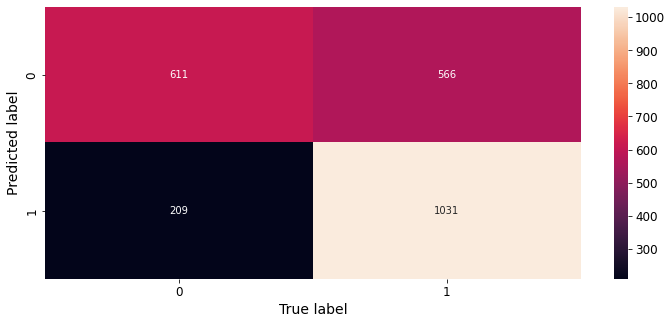

In [ ]:
#some better visualization
import seaborn as sn
import matplotlib.pyplot as plt
%matplotlib inline
f, ax = plt.subplots(figsize=(12,5))
sn.heatmap(con_matrix , annot=True,fmt="d")
ax.set_xlabel('True label', size=14)
ax.set_ylabel('Predicted label',size=14)

plt.rc('xtick', labelsize=12) 
plt.rc('ytick', labelsize=12)
plt.show()

KNN

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
neigh = KNeighborsClassifier(n_neighbors=2)
neigh.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=2)

In [ ]:
neigh.score(X_test,y_test)

0.9139429044269756

In [ ]:
neighPredict = neigh.predict(X_test)

In [ ]:
from sklearn.metrics import precision_recall_fscore_support as score



precision, recall, fscore, support = score(y_test, neighPredict)

print('precision: {}'.format(precision))
print('recall: {}'.format(recall))
print('fscore: {}'.format(fscore))
print('support: {}'.format(support))

precision: [0.86900228 0.9673913 ]
recall: [0.96941376 0.86129032]
fscore: [0.91646586 0.9112628 ]
support: [1177 1240]


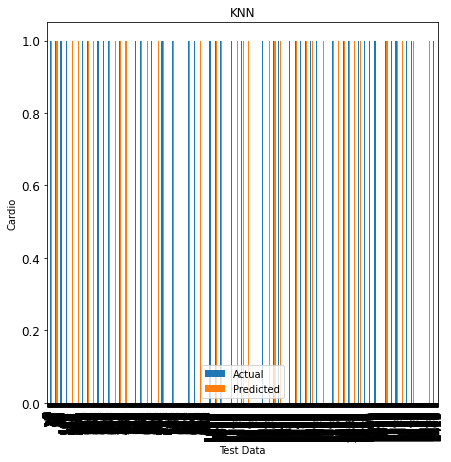

In [ ]:
df = pd.DataFrame({'Actual': y_test, 'Predicted': neighPredict})
df.plot(kind='bar',figsize=(7,7),xlabel='Test Data',ylabel='Cardio',title='KNN')
plt.show()

In [ ]:
#creating the confusion matrix
from sklearn.metrics import confusion_matrix

con_matrix = confusion_matrix(y_test, neighPredict)
con_matrix

array([[1141,   36],
       [ 172, 1068]])

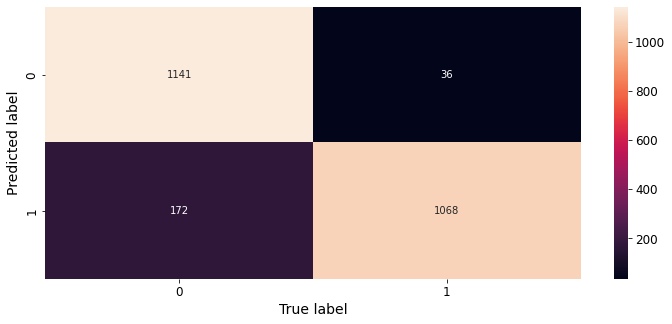

In [ ]:
#some better visualization
import seaborn as sn
import matplotlib.pyplot as plt
%matplotlib inline
f, ax = plt.subplots(figsize=(12,5))
sn.heatmap(con_matrix , annot=True,fmt="d")
ax.set_xlabel('True label', size=14)
ax.set_ylabel('Predicted label',size=14)

plt.rc('xtick', labelsize=12) 
plt.rc('ytick', labelsize=12)
plt.show()

Gradient boosting

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier
gb = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0,max_depth=1, random_state=0).fit(X_train, y_train)
gb.score(X_test, y_test)

0.8129913115432355

In [ ]:
gbPredict = gb.predict(X_test)

In [ ]:
from sklearn.metrics import precision_recall_fscore_support as score



precision, recall, fscore, support = score(y_test, gbPredict)

print('precision: {}'.format(precision))
print('recall: {}'.format(recall))
print('fscore: {}'.format(fscore))
print('support: {}'.format(support))

precision: [0.79884584 0.82724252]
recall: [0.82327952 0.80322581]
fscore: [0.81087866 0.81505728]
support: [1177 1240]


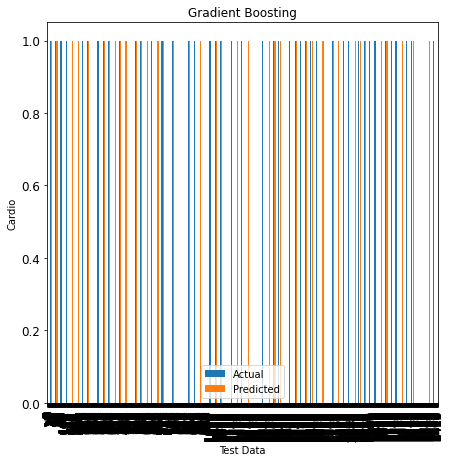

In [ ]:
df = pd.DataFrame({'Actual': y_test, 'Predicted': gbPredict})
df.plot(kind='bar',figsize=(7,7),xlabel='Test Data',ylabel='Cardio',title='Gradient Boosting')
plt.show()

In [ ]:
#creating the confusion matrix
from sklearn.metrics import confusion_matrix

con_matrix = confusion_matrix(y_test, gbPredict)
con_matrix

array([[969, 208],
       [244, 996]])

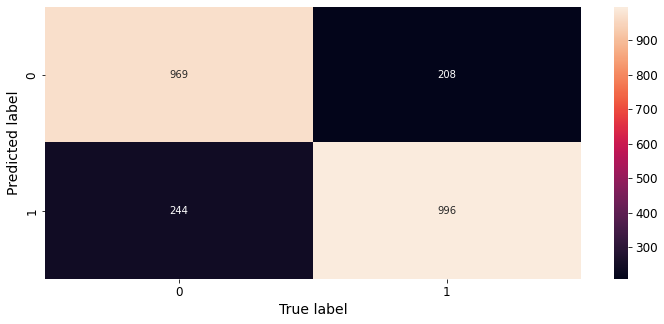

In [ ]:
#some better visualization
import seaborn as sn
import matplotlib.pyplot as plt
%matplotlib inline
f, ax = plt.subplots(figsize=(12,5))
sn.heatmap(con_matrix , annot=True,fmt="d")
ax.set_xlabel('True label', size=14)
ax.set_ylabel('Predicted label',size=14)

plt.rc('xtick', labelsize=12) 
plt.rc('ytick', labelsize=12)
plt.show()